In [1]:
import os
import pandas as  pd
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ======================
# 1. Load Metadata
# ======================
CSV_PATH = "bcn20000_metadata_2025-07-18.csv"
IMG_DIR = "ISIC-images"  # update if your images are in another folder

print("Loading CSV:", CSV_PATH)
df_all = pd.read_csv(CSV_PATH)

# Build severity column from diagnosis_1 or diagnosis_2
df_all["severity"] = df_all["diagnosis_1"].fillna(df_all["diagnosis_2"])

# Build disease column from diagnosis_3
df_all["disease"] = df_all["diagnosis_3"]

# Rename isic_id → image_id
if "image_id" not in df_all.columns:
    if "isic_id" in df_all.columns:
        df_all = df_all.rename(columns={"isic_id": "image_id"})
    else:
        raise KeyError("No column found for image_id or isic_id")

# Drop rows missing required values
required_cols = ["image_id", "disease", "severity"]
df_all = df_all.dropna(subset=required_cols).reset_index(drop=True)

print("Total rows after cleanup:", len(df_all))
print("Disease counts (top 10):")
print(df_all["disease"].value_counts().head(10))
print("Severity counts:")
print(df_all["severity"].value_counts())

# ======================
# 2. Encode labels
# ======================
disease_encoder = LabelEncoder()
severity_encoder = LabelEncoder()

df_all["disease_label"] = disease_encoder.fit_transform(df_all["disease"])
df_all["severity_label"] = severity_encoder.fit_transform(df_all["severity"])

disease_classes = {cls: i for i, cls in enumerate(disease_encoder.classes_)}
severity_classes = {cls: i for i, cls in enumerate(severity_encoder.classes_)}
print("Disease Classes:", disease_classes)
print("Severity Classes:", severity_classes)

# ======================
# 3. Dataset Class
# ======================
class SkinDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["image_id"] + ".jpg")

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        disease_label = torch.tensor(row["disease_label"], dtype=torch.long)
        severity_label = torch.tensor(row["severity_label"], dtype=torch.long)

        return image, disease_label, severity_label

# ======================
# 4. Data Split
# ======================
train_df, val_df = train_test_split(
    df_all, test_size=0.2, stratify=df_all["disease_label"], random_state=42
)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

train_dataset = SkinDataset(train_df, IMG_DIR, transform)
val_dataset = SkinDataset(val_df, IMG_DIR, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# ======================
# 5. Model
# ======================
class MultiTaskViTModel(nn.Module):
    def __init__(self, num_diseases, num_severities):
        super(MultiTaskViTModel, self).__init__()
        weights = ViT_B_16_Weights.IMAGENET1K_V1
        self.vit = vit_b_16(weights=weights)
        self.vit.heads = nn.Identity()

        hidden_dim = 768
        self.disease_head = nn.Linear(hidden_dim, num_diseases)
        self.severity_head = nn.Linear(hidden_dim, num_severities)

    def forward(self, x):
        features = self.vit(x)
        disease_out = self.disease_head(features)
        severity_out = self.severity_head(features)
        return disease_out, severity_out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = MultiTaskViTModel(len(disease_classes), len(severity_classes)).to(device)

# ======================
# 6. Loss & Optimizer
# ======================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ======================
# 7. Training Loop
# ======================
def train_model(model, train_loader, val_loader, epochs=27):
    best_val_loss = float("inf")

    for epoch in range(epochs):
        model.train()
        train_loss, correct_disease, correct_severity, total = 0, 0, 0, 0

        for images, diseases, severities in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, diseases, severities = images.to(device), diseases.to(device), severities.to(device)

            optimizer.zero_grad()
            disease_out, severity_out = model(images)
            loss = criterion(disease_out, diseases) + criterion(severity_out, severities)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # accuracy
            _, pred_disease = torch.max(disease_out, 1)
            _, pred_severity = torch.max(severity_out, 1)
            correct_disease += (pred_disease == diseases).sum().item()
            correct_severity += (pred_severity == severities).sum().item()
            total += diseases.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_acc_disease = 100 * correct_disease / total
        train_acc_severity = 100 * correct_severity / total

        # Validation
        model.eval()
        val_loss, val_correct_disease, val_correct_severity, val_total = 0, 0, 0, 0
        with torch.no_grad():
            for images, diseases, severities in val_loader:
                images, diseases, severities = images.to(device), diseases.to(device), severities.to(device)

                disease_out, severity_out = model(images)
                loss = criterion(disease_out, diseases) + criterion(severity_out, severities)
                val_loss += loss.item()

                _, pred_disease = torch.max(disease_out, 1)
                _, pred_severity = torch.max(severity_out, 1)
                val_correct_disease += (pred_disease == diseases).sum().item()
                val_correct_severity += (pred_severity == severities).sum().item()
                val_total += diseases.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc_disease = 100 * val_correct_disease / val_total
        val_acc_severity = 100 * val_correct_severity / val_total

        print(f"Epoch {epoch+1}: "
              f"Train Loss={avg_train_loss:.4f}, "
              f"Val Loss={avg_val_loss:.4f}, "
              f"Train Acc (Disease)={train_acc_disease:.2f}%, "
              f"Train Acc (Severity)={train_acc_severity:.2f}%, "
              f"Val Acc (Disease)={val_acc_disease:.2f}%, "
              f"Val Acc (Severity)={val_acc_severity:.2f}%")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "new_best_vit_model.pth")
            print("✅ Saved new best model")

# ======================
# 8. Run Training
# ======================
train_model(model, train_loader, val_loader, epochs=30)


Loading CSV: bcn20000_metadata_2025-07-18.csv
Total rows after cleanup: 17639
Disease counts (top 10):
disease
Nevus                           5647
Melanoma, NOS                   4003
Basal cell carcinoma            3676
Seborrheic keratosis            1268
Solar or actinic keratosis      1088
Melanoma metastasis              633
Squamous cell carcinoma, NOS     559
Scar                             314
Solar lentigo                    283
Dermatofibroma                   168
Name: count, dtype: int64
Severity counts:
severity
Malignant        8871
Benign           7680
Indeterminate    1088
Name: count, dtype: int64
Disease Classes: {'Basal cell carcinoma': 0, 'Dermatofibroma': 1, 'Melanoma metastasis': 2, 'Melanoma, NOS': 3, 'Nevus': 4, 'Scar': 5, 'Seborrheic keratosis': 6, 'Solar lentigo': 7, 'Solar or actinic keratosis': 8, 'Squamous cell carcinoma, NOS': 9}
Severity Classes: {'Benign': 0, 'Indeterminate': 1, 'Malignant': 2}
Using device: cuda


Epoch 1/30: 100%|██████████| 441/441 [05:23<00:00,  1.36it/s]


Epoch 1: Train Loss=1.8836, Val Loss=1.6756, Train Acc (Disease)=58.44%, Train Acc (Severity)=70.70%, Val Acc (Disease)=63.46%, Val Acc (Severity)=74.26%
✅ Saved new best model


Epoch 2/30: 100%|██████████| 441/441 [06:06<00:00,  1.20it/s]


Epoch 2: Train Loss=1.4769, Val Loss=1.5623, Train Acc (Disease)=68.17%, Train Acc (Severity)=77.63%, Val Acc (Disease)=66.55%, Val Acc (Severity)=77.15%
✅ Saved new best model


Epoch 3/30: 100%|██████████| 441/441 [05:30<00:00,  1.33it/s]


Epoch 3: Train Loss=1.1426, Val Loss=1.8107, Train Acc (Disease)=74.97%, Train Acc (Severity)=82.90%, Val Acc (Disease)=63.69%, Val Acc (Severity)=72.48%


Epoch 4/30: 100%|██████████| 441/441 [05:31<00:00,  1.33it/s]


Epoch 4: Train Loss=0.8331, Val Loss=1.4194, Train Acc (Disease)=81.94%, Train Acc (Severity)=87.89%, Val Acc (Disease)=71.15%, Val Acc (Severity)=79.79%
✅ Saved new best model


Epoch 5/30: 100%|██████████| 441/441 [05:29<00:00,  1.34it/s]


Epoch 5: Train Loss=0.5544, Val Loss=1.3915, Train Acc (Disease)=87.88%, Train Acc (Severity)=92.38%, Val Acc (Disease)=74.09%, Val Acc (Severity)=81.75%
✅ Saved new best model


Epoch 6/30: 100%|██████████| 441/441 [05:28<00:00,  1.34it/s]


Epoch 6: Train Loss=0.3916, Val Loss=1.6094, Train Acc (Disease)=91.69%, Train Acc (Severity)=94.82%, Val Acc (Disease)=72.25%, Val Acc (Severity)=80.58%


Epoch 7/30: 100%|██████████| 441/441 [05:24<00:00,  1.36it/s]


Epoch 7: Train Loss=0.3070, Val Loss=1.5729, Train Acc (Disease)=93.30%, Train Acc (Severity)=95.78%, Val Acc (Disease)=72.99%, Val Acc (Severity)=80.95%


Epoch 8/30: 100%|██████████| 441/441 [05:26<00:00,  1.35it/s]


Epoch 8: Train Loss=0.2288, Val Loss=1.6418, Train Acc (Disease)=95.23%, Train Acc (Severity)=97.13%, Val Acc (Disease)=75.17%, Val Acc (Severity)=82.65%


Epoch 9/30: 100%|██████████| 441/441 [05:35<00:00,  1.31it/s]


Epoch 9: Train Loss=0.2109, Val Loss=1.6925, Train Acc (Disease)=95.62%, Train Acc (Severity)=97.21%, Val Acc (Disease)=73.81%, Val Acc (Severity)=81.26%


Epoch 10/30: 100%|██████████| 441/441 [05:34<00:00,  1.32it/s]


Epoch 10: Train Loss=0.1634, Val Loss=1.6319, Train Acc (Disease)=96.46%, Train Acc (Severity)=97.87%, Val Acc (Disease)=75.26%, Val Acc (Severity)=82.91%


Epoch 11/30: 100%|██████████| 441/441 [05:25<00:00,  1.36it/s]


Epoch 11: Train Loss=0.1571, Val Loss=1.6951, Train Acc (Disease)=96.67%, Train Acc (Severity)=97.94%, Val Acc (Disease)=74.66%, Val Acc (Severity)=82.11%


Epoch 12/30: 100%|██████████| 441/441 [05:26<00:00,  1.35it/s]


Epoch 12: Train Loss=0.1562, Val Loss=1.7348, Train Acc (Disease)=96.50%, Train Acc (Severity)=97.89%, Val Acc (Disease)=73.95%, Val Acc (Severity)=82.51%


Epoch 13/30: 100%|██████████| 441/441 [05:23<00:00,  1.36it/s]


Epoch 13: Train Loss=0.1410, Val Loss=1.8278, Train Acc (Disease)=96.98%, Train Acc (Severity)=98.29%, Val Acc (Disease)=75.09%, Val Acc (Severity)=82.54%


Epoch 14/30: 100%|██████████| 441/441 [05:36<00:00,  1.31it/s]


Epoch 14: Train Loss=0.1263, Val Loss=1.9238, Train Acc (Disease)=97.57%, Train Acc (Severity)=98.34%, Val Acc (Disease)=74.35%, Val Acc (Severity)=82.20%


Epoch 15/30: 100%|██████████| 441/441 [05:29<00:00,  1.34it/s]


Epoch 15: Train Loss=0.1233, Val Loss=1.9348, Train Acc (Disease)=97.48%, Train Acc (Severity)=98.48%, Val Acc (Disease)=73.53%, Val Acc (Severity)=81.49%


Epoch 16/30: 100%|██████████| 441/441 [05:27<00:00,  1.35it/s]


Epoch 16: Train Loss=0.1197, Val Loss=2.0222, Train Acc (Disease)=97.40%, Train Acc (Severity)=98.39%, Val Acc (Disease)=73.38%, Val Acc (Severity)=80.58%


Epoch 17/30: 100%|██████████| 441/441 [05:25<00:00,  1.35it/s]


Epoch 17: Train Loss=0.1203, Val Loss=1.8183, Train Acc (Disease)=97.52%, Train Acc (Severity)=98.44%, Val Acc (Disease)=74.77%, Val Acc (Severity)=81.89%


Epoch 18/30: 100%|██████████| 441/441 [05:25<00:00,  1.35it/s]


Epoch 18: Train Loss=0.1011, Val Loss=2.0106, Train Acc (Disease)=97.84%, Train Acc (Severity)=98.70%, Val Acc (Disease)=74.80%, Val Acc (Severity)=82.43%


Epoch 19/30: 100%|██████████| 441/441 [05:41<00:00,  1.29it/s]


Epoch 19: Train Loss=0.0776, Val Loss=1.9942, Train Acc (Disease)=98.52%, Train Acc (Severity)=99.03%, Val Acc (Disease)=73.50%, Val Acc (Severity)=81.83%


Epoch 20/30: 100%|██████████| 441/441 [05:32<00:00,  1.33it/s]


Epoch 20: Train Loss=0.1224, Val Loss=1.9589, Train Acc (Disease)=97.51%, Train Acc (Severity)=98.26%, Val Acc (Disease)=75.03%, Val Acc (Severity)=81.97%


Epoch 21/30: 100%|██████████| 441/441 [05:24<00:00,  1.36it/s]


Epoch 21: Train Loss=0.0832, Val Loss=1.8531, Train Acc (Disease)=98.30%, Train Acc (Severity)=99.06%, Val Acc (Disease)=74.35%, Val Acc (Severity)=82.11%


Epoch 22/30: 100%|██████████| 441/441 [05:39<00:00,  1.30it/s]


Epoch 22: Train Loss=0.1011, Val Loss=1.9698, Train Acc (Disease)=97.77%, Train Acc (Severity)=98.71%, Val Acc (Disease)=74.40%, Val Acc (Severity)=81.86%


Epoch 23/30: 100%|██████████| 441/441 [05:34<00:00,  1.32it/s]


Epoch 23: Train Loss=0.0927, Val Loss=1.8572, Train Acc (Disease)=98.06%, Train Acc (Severity)=98.81%, Val Acc (Disease)=75.09%, Val Acc (Severity)=82.62%


Epoch 24/30: 100%|██████████| 441/441 [05:31<00:00,  1.33it/s]


Epoch 24: Train Loss=0.0961, Val Loss=1.8845, Train Acc (Disease)=97.94%, Train Acc (Severity)=98.75%, Val Acc (Disease)=74.66%, Val Acc (Severity)=81.55%


Epoch 25/30: 100%|██████████| 441/441 [05:27<00:00,  1.35it/s]


Epoch 25: Train Loss=0.0722, Val Loss=1.9718, Train Acc (Disease)=98.45%, Train Acc (Severity)=99.01%, Val Acc (Disease)=74.32%, Val Acc (Severity)=82.14%


Epoch 26/30: 100%|██████████| 441/441 [05:26<00:00,  1.35it/s]


Epoch 26: Train Loss=0.0865, Val Loss=2.0943, Train Acc (Disease)=98.25%, Train Acc (Severity)=98.84%, Val Acc (Disease)=73.89%, Val Acc (Severity)=81.18%


Epoch 27/30: 100%|██████████| 441/441 [05:25<00:00,  1.36it/s]


Epoch 27: Train Loss=0.0992, Val Loss=1.9001, Train Acc (Disease)=97.92%, Train Acc (Severity)=98.66%, Val Acc (Disease)=73.87%, Val Acc (Severity)=82.23%


Epoch 28/30: 100%|██████████| 441/441 [05:28<00:00,  1.34it/s]


Epoch 28: Train Loss=0.0773, Val Loss=1.9620, Train Acc (Disease)=98.43%, Train Acc (Severity)=98.94%, Val Acc (Disease)=74.04%, Val Acc (Severity)=80.84%


Epoch 29/30: 100%|██████████| 441/441 [05:25<00:00,  1.35it/s]


Epoch 29: Train Loss=0.0621, Val Loss=2.1268, Train Acc (Disease)=98.72%, Train Acc (Severity)=99.27%, Val Acc (Disease)=74.83%, Val Acc (Severity)=82.14%


Epoch 30/30: 100%|██████████| 441/441 [05:34<00:00,  1.32it/s]


Epoch 30: Train Loss=0.0823, Val Loss=1.9488, Train Acc (Disease)=98.16%, Train Acc (Severity)=98.94%, Val Acc (Disease)=75.82%, Val Acc (Severity)=82.37%


In [10]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import pickle

CSV_PATH = "bcn20000_metadata_2025-07-18.csv"

df_all = pd.read_csv(CSV_PATH)

# Build severity column from diagnosis_1 or diagnosis_2
df_all["severity"] = df_all["diagnosis_1"].fillna(df_all["diagnosis_2"])

# Build disease column from diagnosis_3
df_all["disease"] = df_all["diagnosis_3"]

# Rename isic_id → image_id
if "image_id" not in df_all.columns:
    if "isic_id" in df_all.columns:
        df_all = df_all.rename(columns={"isic_id": "image_id"})
    else:
        raise KeyError("No column found for image_id or isic_id")

# Drop rows missing required values
required_cols = ["image_id", "disease", "severity"]
df_all = df_all.dropna(subset=required_cols).reset_index(drop=True)


In [11]:
disease_encoder = LabelEncoder()
severity_encoder = LabelEncoder()

df_all["disease_label"] = disease_encoder.fit_transform(df_all["disease"])
df_all["severity_label"] = severity_encoder.fit_transform(df_all["severity"])

# Save encoders
with open("disease_encoder.pkl", "wb") as f:
    pickle.dump(disease_encoder, f)

with open("severity_encoder.pkl", "wb") as f:
    pickle.dump(severity_encoder, f)

print("✅ Saved disease_encoder.pkl and severity_encoder.pkl")


✅ Saved disease_encoder.pkl and severity_encoder.pkl


In [13]:
import torch
from torchvision import transforms
from PIL import Image
import pickle
from torchvision.models import vit_b_16, ViT_B_16_Weights
import torch.nn as nn

# ======================
# 1. Load Encoders
# ======================
with open("disease_encoder.pkl", "rb") as f:
    disease_encoder = pickle.load(f)

with open("severity_encoder.pkl", "rb") as f:
    severity_encoder = pickle.load(f)

# ======================
# 2. Define Model
# ======================
class MultiTaskViTModel(nn.Module):
    def __init__(self, num_diseases, num_severities):
        super(MultiTaskViTModel, self).__init__()
        weights = ViT_B_16_Weights.IMAGENET1K_V1
        self.vit = vit_b_16(weights=weights)
        self.vit.heads = nn.Identity()

        hidden_dim = 768
        self.disease_head = nn.Linear(hidden_dim, num_diseases)
        self.severity_head = nn.Linear(hidden_dim, num_severities)

    def forward(self, x):
        features = self.vit(x)
        disease_out = self.disease_head(features)
        severity_out = self.severity_head(features)
        return disease_out, severity_out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = MultiTaskViTModel(len(disease_encoder.classes_), len(severity_encoder.classes_))
model.load_state_dict(torch.load("new_best_vit_model.pth", map_location=device))
model.to(device)
model.eval()  # Important: set model to evaluation mode

# ======================
# 3. Define Image Transform
# ======================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

# ======================
# 4. Predict Function
# ======================
def predict_image(image_path):
    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)  # add batch dimension

    # Forward pass
    with torch.no_grad():
        disease_out, severity_out = model(image_tensor)

    # Get predicted class indices
    pred_disease_idx = torch.argmax(disease_out, dim=1).item()
    pred_severity_idx = torch.argmax(severity_out, dim=1).item()

    # Convert indices to original labels
    pred_disease_label = disease_encoder.inverse_transform([pred_disease_idx])[0]
    pred_severity_label = severity_encoder.inverse_transform([pred_severity_idx])[0]

    return pred_disease_label, pred_severity_label

# ======================
# 5. Example Usage
# ======================
image_path = "ISIC-images/ISIC_0053462.jpg"  # Replace with your image
disease, severity = predict_image(image_path)
print(f"Predicted Disease: {disease}")
print(f"Predicted Severity: {severity}")


Predicted Disease: Solar lentigo
Predicted Severity: Benign


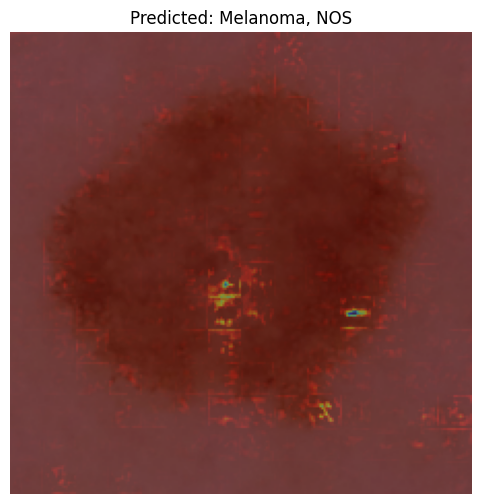

Predicted Disease: Melanoma, NOS


In [17]:
import torch
from torchvision import transforms
from PIL import Image
import pickle
from torchvision.models import vit_b_16, ViT_B_16_Weights
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ======================
# 1. Load Encoders
# ======================
with open("disease_encoder.pkl", "rb") as f:
    disease_encoder = pickle.load(f)

with open("severity_encoder.pkl", "rb") as f:
    severity_encoder = pickle.load(f)

# ======================
# 2. Define Model
# ======================
class MultiTaskViTModel(nn.Module):
    def __init__(self, num_diseases, num_severities):
        super(MultiTaskViTModel, self).__init__()
        weights = ViT_B_16_Weights.IMAGENET1K_V1
        self.vit = vit_b_16(weights=weights)
        self.vit.heads = nn.Identity()
        hidden_dim = 768
        self.disease_head = nn.Linear(hidden_dim, num_diseases)
        self.severity_head = nn.Linear(hidden_dim, num_severities)

    def forward(self, x):
        features = self.vit(x)
        disease_out = self.disease_head(features)
        severity_out = self.severity_head(features)
        return disease_out, severity_out, features  # return features for Grad-CAM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultiTaskViTModel(len(disease_encoder.classes_), len(severity_encoder.classes_))
model.load_state_dict(torch.load("new_best_vit_model.pth", map_location=device))
model.to(device)
model.eval()

# ======================
# 3. Image Transform
# ======================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

# ======================
# 4. Grad-CAM Function
# ======================
def gradcam(image_path):
    # Load and preprocess
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Enable gradients for features
    image_tensor.requires_grad = True
    
    # Forward pass
    disease_out, severity_out, features = model(image_tensor)
    pred_idx = torch.argmax(disease_out, dim=1).item()
    
    # Backward pass for Grad-CAM
    model.zero_grad()
    disease_out[0, pred_idx].backward(retain_graph=True)
    
    # Get gradients and features
    gradients = image_tensor.grad.cpu().numpy()[0]  # (3, 224, 224)
    activations = features.detach().cpu().numpy()[0]  # (768,)
    
    # Grad-CAM for ViT is tricky since it's transformer-based
    # We'll use a simplified approach: average attention over channels
    grad_cam_map = np.mean(gradients, axis=0)  # (224, 224)
    grad_cam_map = np.maximum(grad_cam_map, 0)  # ReLU
    grad_cam_map = cv2.resize(grad_cam_map, (224, 224))
    grad_cam_map = grad_cam_map - grad_cam_map.min()
    grad_cam_map = grad_cam_map / grad_cam_map.max()
    
    # Overlay heatmap on original image
    img = np.array(image.resize((224, 224)))
    heatmap = cv2.applyColorMap(np.uint8(255*grad_cam_map), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    
    # Show image
    plt.figure(figsize=(6,6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"Predicted: {disease_encoder.inverse_transform([pred_idx])[0]}")
    plt.show()

    return disease_encoder.inverse_transform([pred_idx])[0]

# ======================
# 5. Example Usage
# ======================
image_path = "ISIC-images/ISIC_0053492.jpg"
predicted_disease = gradcam(image_path)
print(f"Predicted Disease: {predicted_disease}")


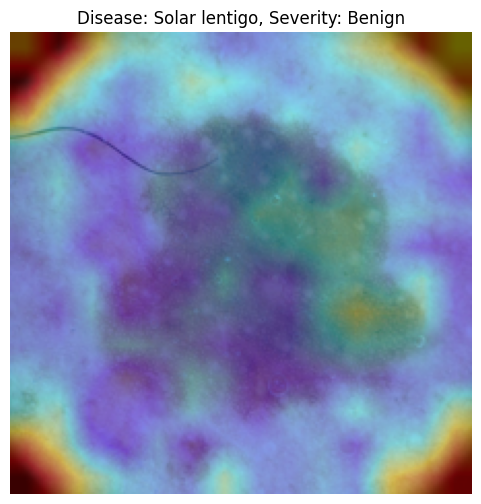

Predicted Disease: Solar lentigo
Predicted Severity: Benign


In [18]:
import torch
from torchvision import transforms
from PIL import Image
import pickle
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision.models import vit_b_16, ViT_B_16_Weights

# ======================
# Load Encoders
# ======================
with open("disease_encoder.pkl", "rb") as f:
    disease_encoder = pickle.load(f)

with open("severity_encoder.pkl", "rb") as f:
    severity_encoder = pickle.load(f)

# ======================
# Define Model
# ======================
class MultiTaskViTModel(nn.Module):
    def __init__(self, num_diseases, num_severities):
        super().__init__()
        weights = ViT_B_16_Weights.IMAGENET1K_V1
        self.vit = vit_b_16(weights=weights)
        self.vit.heads = nn.Identity()  # remove classification head
        self.disease_head = nn.Linear(768, num_diseases)
        self.severity_head = nn.Linear(768, num_severities)
        
        # store activations for Grad-CAM
        self.activations = None
        self.vit.encoder.layers[-1].register_forward_hook(self.save_activations)

    def save_activations(self, module, input, output):
        # output shape: [batch, tokens, 768]
        self.activations = output[:, 1:, :]  # exclude CLS token

    def forward(self, x):
        features = self.vit(x)  # shape: [batch, 768]
        disease_out = self.disease_head(features)
        severity_out = self.severity_head(features)
        return disease_out, severity_out

# ======================
# Device & Load Model
# ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskViTModel(len(disease_encoder.classes_), len(severity_encoder.classes_))
model.load_state_dict(torch.load("new_best_vit_model.pth", map_location=device))
model.to(device)
model.eval()

# ======================
# Image Transform
# ======================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

# ======================
# Grad-CAM Heatmap
# ======================
def generate_heatmap(activations):
    # activations: [tokens, 768]
    cam = activations.mean(-1).detach().cpu().numpy()  # average across channels
    cam = cam.reshape(14, 14)  # 16x16 patches → 14x14 for vit_b_16
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    return cam

# ======================
# Prediction & Overlay
# ======================
def predict_with_gradcam(image_path):
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        disease_out, severity_out = model(img_tensor)

    # Predicted labels
    disease_idx = torch.argmax(disease_out, dim=1).item()
    severity_idx = torch.argmax(severity_out, dim=1).item()
    disease_label = disease_encoder.inverse_transform([disease_idx])[0]
    severity_label = severity_encoder.inverse_transform([severity_idx])[0]

    # Generate heatmap
    cam = generate_heatmap(model.activations[0])
    img_np = np.array(image.resize((224, 224)))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(6,6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"Disease: {disease_label}, Severity: {severity_label}")
    plt.show()

    return disease_label, severity_label

# ======================
# Example Usage
# ======================
image_path = "ISIC-images/ISIC_0053462.jpg"
disease, severity = predict_with_gradcam(image_path)
print(f"Predicted Disease: {disease}")
print(f"Predicted Severity: {severity}")


In [29]:
import torch
from torchvision import transforms
from PIL import Image
import pickle
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision.models import vit_b_16, ViT_B_16_Weights

# ======================
# Load Encoders
# ======================
with open("disease_encoder.pkl", "rb") as f:
    disease_encoder = pickle.load(f)

with open("severity_encoder.pkl", "rb") as f:
    severity_encoder = pickle.load(f)

# ======================
# Define Model
# ======================
class MultiTaskViTModel(nn.Module):
    def __init__(self, num_diseases, num_severities):
        super().__init__()
        weights = ViT_B_16_Weights.IMAGENET1K_V1
        self.vit = vit_b_16(weights=weights)
        self.vit.heads = nn.Identity()  # remove classification head
        self.disease_head = nn.Linear(768, num_diseases)
        self.severity_head = nn.Linear(768, num_severities)
        
        # store activations for Grad-CAM
        self.activations = None
        self.vit.encoder.layers[-1].register_forward_hook(self.save_activations)

    def save_activations(self, module, input, output):
        # output shape: [batch, tokens, 768]
        self.activations = output[:, 1:, :]  # exclude CLS token

    def forward(self, x):
        features = self.vit(x)  # shape: [batch, 768]
        disease_out = self.disease_head(features)
        severity_out = self.severity_head(features)
        return disease_out, severity_out

# ======================
# Device & Load Model
# ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskViTModel(len(disease_encoder.classes_), len(severity_encoder.classes_))
model.load_state_dict(torch.load("new_best_vit_model.pth", map_location=device))
model.to(device)
model.eval()

# ======================
# Image Transform
# ======================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

# ======================
# Grad-CAM Heatmap
# ======================
def generate_heatmap(activations):
    # activations: [tokens, 768]
    cam = activations.mean(-1).detach().cpu().numpy()  # average across channels
    cam = cam.reshape(14, 14)  # 16x16 patches → 14x14 for vit_b_16
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    return cam

# ======================
# Prediction & Overlay
# ======================
def predict_with_gradcam(image_path):
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        disease_out, severity_out = model(img_tensor)

    # Predicted labels
    disease_idx = torch.argmax(disease_out, dim=1).item()
    severity_idx = torch.argmax(severity_out, dim=1).item()
    disease_label = disease_encoder.inverse_transform([disease_idx])[0]
    severity_label = severity_encoder.inverse_transform([severity_idx])[0]

    # Generate heatmap
    cam = generate_heatmap(model.activations[0])
    img_np = np.array(image.resize((224, 224)))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    # Show original and overlay side by side
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.axis("off")
    plt.title("Original Image")

    # Grad-CAM overlay
    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"Grad-CAM\nDisease: {disease_label}, Severity: {severity_label}")

    plt.tight_layout()
    plt.show()

    return disease_label, severity_label

# ======================
# Example Usage
# ======================
image_path = "ISIC-images/ISIC_0053459.jpg"
print(f"orginal image: {image_path}")
print(f"Predicted Disease: {disease}")
print(f"Predicted Severity: {severity}")


orginal image: ISIC-images/ISIC_0053459.jpg
Predicted Disease: Nevus
Predicted Severity: Benign


In [28]:
import torch
from torchvision import transforms
from PIL import Image
import pickle
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision.models import vit_b_16, ViT_B_16_Weights

# ======================
# Load Encoders
# ======================
with open("disease_encoder.pkl", "rb") as f:
    disease_encoder = pickle.load(f)

with open("severity_encoder.pkl", "rb") as f:
    severity_encoder = pickle.load(f)

# ======================
# Define Model
# ======================
class MultiTaskViTModel(nn.Module):
    def __init__(self, num_diseases, num_severities):
        super().__init__()
        weights = ViT_B_16_Weights.IMAGENET1K_V1
        self.vit = vit_b_16(weights=weights)
        self.vit.heads = nn.Identity()  # remove classification head
        self.disease_head = nn.Linear(768, num_diseases)
        self.severity_head = nn.Linear(768, num_severities)
        
        # store activations for Grad-CAM
        self.activations = None
        self.vit.encoder.layers[-1].register_forward_hook(self.save_activations)

    def save_activations(self, module, input, output):
        # output shape: [batch, tokens, 768]
        self.activations = output[:, 1:, :]  # exclude CLS token

    def forward(self, x):
        features = self.vit(x)  # shape: [batch, 768]
        disease_out = self.disease_head(features)
        severity_out = self.severity_head(features)
        return disease_out, severity_out

# ======================
# Device & Load Model
# ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskViTModel(len(disease_encoder.classes_), len(severity_encoder.classes_))
model.load_state_dict(torch.load("new_best_vit_model.pth", map_location=device))
model.to(device)
model.eval()

# ======================
# Image Transform
# ======================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

# ======================
# Grad-CAM Heatmap
# ======================
def generate_heatmap(activations):
    # activations: [tokens, 768]
    cam = activations.mean(-1).detach().cpu().numpy()  # average across channels
    cam = cam.reshape(14, 14)  # 16x16 patches → 14x14 for vit_b_16
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    return cam

# ======================
# Prediction & Overlay
# ======================
def predict_with_gradcam(image_path):
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        disease_out, severity_out = model(img_tensor)

    # Predicted labels
    disease_idx = torch.argmax(disease_out, dim=1).item()
    severity_idx = torch.argmax(severity_out, dim=1).item()
    disease_label = disease_encoder.inverse_transform([disease_idx])[0]
    severity_label = severity_encoder.inverse_transform([severity_idx])[0]

    # Generate heatmap
    cam = generate_heatmap(model.activations[0])
    img_np = np.array(image.resize((224, 224)))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    # Show original and overlay side by side
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.axis("off")
    plt.title("Original Image")

    # Grad-CAM overlay
    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"Grad-CAM\nDisease: {disease_label}, Severity: {severity_label}")

    plt.tight_layout()
    plt.show()

    return disease_label, severity_label

# ======================
# Example Usage
# ======================
image_path = "ISIC-images/ISIC_0053582.jpg"
print(f"orginal image: {image_path}")
print(f"Predicted Disease: {disease}")
print(f"Predicted Severity: {severity}")


orginal image: ISIC-images/ISIC_0053582.jpg
Predicted Disease: Nevus
Predicted Severity: Benign


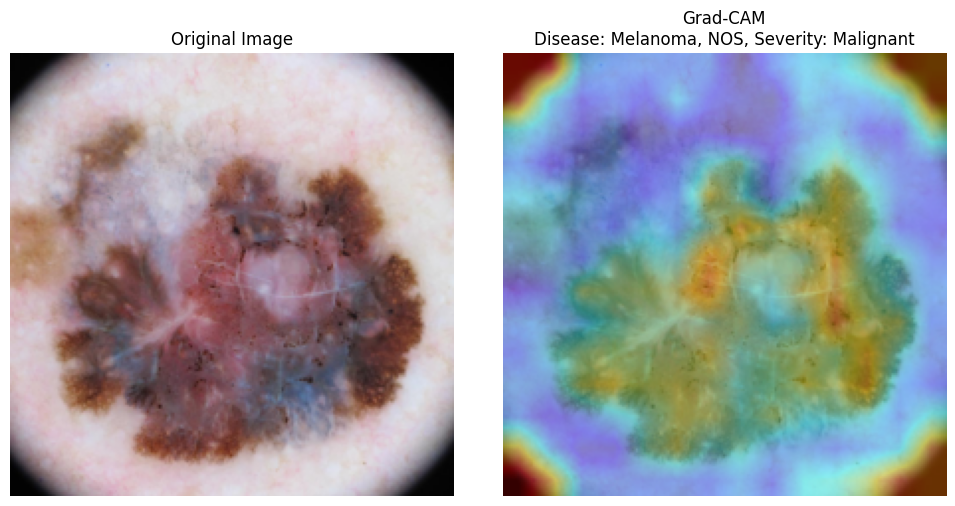

orginal image: ISIC-images/ISIC_0053582.jpg
Predicted Disease: Melanoma, NOS
Predicted Severity: Malignant


In [32]:
import torch
from torchvision import transforms
from PIL import Image
import pickle
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision.models import vit_b_16, ViT_B_16_Weights

# ======================
# Load Encoders
# ======================
with open("disease_encoder.pkl", "rb") as f:
    disease_encoder = pickle.load(f)

with open("severity_encoder.pkl", "rb") as f:
    severity_encoder = pickle.load(f)

# ======================
# Define Model
# ======================
class MultiTaskViTModel(nn.Module):
    def __init__(self, num_diseases, num_severities):
        super().__init__()
        weights = ViT_B_16_Weights.IMAGENET1K_V1
        self.vit = vit_b_16(weights=weights)
        self.vit.heads = nn.Identity()  # remove classification head
        self.disease_head = nn.Linear(768, num_diseases)
        self.severity_head = nn.Linear(768, num_severities)
        
        # store activations for Grad-CAM
        self.activations = None
        self.vit.encoder.layers[-1].register_forward_hook(self.save_activations)

    def save_activations(self, module, input, output):
        # output shape: [batch, tokens, 768]
        self.activations = output[:, 1:, :]  # exclude CLS token

    def forward(self, x):
        features = self.vit(x)  # shape: [batch, 768]
        disease_out = self.disease_head(features)
        severity_out = self.severity_head(features)
        return disease_out, severity_out

# ======================
# Device & Load Model
# ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskViTModel(len(disease_encoder.classes_), len(severity_encoder.classes_))
model.load_state_dict(torch.load("new_best_vit_model.pth", map_location=device))
model.to(device)
model.eval()

# ======================
# Image Transform
# ======================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

# ======================
# Grad-CAM Heatmap
# ======================
def generate_heatmap(activations):
    # activations: [tokens, 768]
    cam = activations.mean(-1).detach().cpu().numpy()  # average across channels
    cam = cam.reshape(14, 14)  # 16x16 patches → 14x14 for vit_b_16
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    return cam

# ======================
# Prediction & Overlay
# ======================
def predict_with_gradcam(image_path):
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        disease_out, severity_out = model(img_tensor)

    # Predicted labels
    disease_idx = torch.argmax(disease_out, dim=1).item()
    severity_idx = torch.argmax(severity_out, dim=1).item()
    disease_label = disease_encoder.inverse_transform([disease_idx])[0]
    severity_label = severity_encoder.inverse_transform([severity_idx])[0]

    # Generate heatmap
    cam = generate_heatmap(model.activations[0])
    img_np = np.array(image.resize((224, 224)))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)


    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.axis("off")
    plt.title("Original Image")


    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"Grad-CAM\nDisease: {disease_label}, Severity: {severity_label}")

    plt.tight_layout()
    plt.show()

    return disease_label, severity_label


image_path = "ISIC-images/ISIC_0053582.jpg"
disease, severity = predict_with_gradcam(image_path)
print(f"orginal image: {image_path}")
print(f"Predicted Disease: {disease}")
print(f"Predicted Severity: {severity}")


In [10]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pickle


In [11]:
with open("disease_encoder.pkl", "rb") as f:
    disease_encoder = pickle.load(f)

with open("severity_encoder.pkl", "rb") as f:
    severity_encoder = pickle.load(f)


In [12]:
CSV_PATH = "bcn20000_metadata_2025-07-18.csv"
IMG_DIR = "ISIC-images"

df_all = pd.read_csv(CSV_PATH)
df_all["severity"] = df_all["diagnosis_1"].fillna(df_all["diagnosis_2"])
df_all["disease"] = df_all["diagnosis_3"]
if "image_id" not in df_all.columns and "isic_id" in df_all.columns:
    df_all.rename(columns={"isic_id":"image_id"}, inplace=True)
required_cols = ["image_id","disease","severity"]
df_all = df_all.dropna(subset=required_cols).reset_index(drop=True)

df_all["disease_label"] = disease_encoder.transform(df_all["disease"])
df_all["severity_label"] = severity_encoder.transform(df_all["severity"])

train_df, val_df = train_test_split(df_all, test_size=0.2, 
                                    stratify=df_all["disease_label"], 
                                    random_state=42)


In [13]:
class SkinDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["image_id"] + ".jpg")
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Missing image: {img_path}")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        disease_label = torch.tensor(row["disease_label"], dtype=torch.long)
        severity_label = torch.tensor(row["severity_label"], dtype=torch.long)
        return image, disease_label, severity_label


In [14]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

val_dataset = SkinDataset(val_df, IMG_DIR, transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [15]:
class MultiTaskViTModel(nn.Module):
    def __init__(self, num_diseases, num_severities):
        super().__init__()
        weights = ViT_B_16_Weights.IMAGENET1K_V1
        self.vit = vit_b_16(weights=weights)
        self.vit.heads = nn.Identity()
        self.disease_head = nn.Linear(768, num_diseases)
        self.severity_head = nn.Linear(768, num_severities)

    def forward(self, x):
        features = self.vit(x)
        disease_out = self.disease_head(features)
        severity_out = self.severity_head(features)
        return disease_out, severity_out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskViTModel(len(disease_encoder.classes_), len(severity_encoder.classes_))
model.load_state_dict(torch.load("new_best_vit_model.pth", map_location=device))
model.to(device)
model.eval()


MultiTaskViTModel(
  (vit): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1):

In [18]:
all_disease_preds = []
all_disease_labels = []

all_severity_preds = []
all_severity_labels = []

model.eval()
with torch.no_grad():
    for images, disease_labels, severity_labels in val_loader:
        images = images.to(device)
        disease_labels = disease_labels.to(device)
        severity_labels = severity_labels.to(device)

        disease_out, severity_out = model(images)
        disease_pred = torch.argmax(disease_out, dim=1)
        severity_pred = torch.argmax(severity_out, dim=1)

        all_disease_preds.extend(disease_pred.cpu().numpy())
        all_disease_labels.extend(disease_labels.cpu().numpy())
        all_severity_preds.extend(severity_pred.cpu().numpy())
        all_severity_labels.extend(severity_labels.cpu().numpy())

# Precision, Recall, F1-score
print("=== Disease Classification Report ===")
print(classification_report(all_disease_labels, all_disease_preds,
                            target_names=disease_encoder.classes_, zero_division=0))

print("=== Severity Classification Report ===")
print(classification_report(all_severity_labels, all_severity_preds,
                            target_names=severity_encoder.classes_, zero_division=0))


=== Disease Classification Report ===
                              precision    recall  f1-score   support

        Basal cell carcinoma       0.73      0.83      0.78       735
              Dermatofibroma       0.89      0.48      0.63        33
         Melanoma metastasis       0.64      0.61      0.63       127
               Melanoma, NOS       0.74      0.80      0.77       801
                       Nevus       0.87      0.80      0.83      1129
                        Scar       0.63      0.27      0.38        63
        Seborrheic keratosis       0.57      0.63      0.60       254
               Solar lentigo       0.36      0.16      0.22        56
  Solar or actinic keratosis       0.57      0.57      0.57       218
Squamous cell carcinoma, NOS       0.61      0.54      0.57       112

                    accuracy                           0.74      3528
                   macro avg       0.66      0.57      0.60      3528
                weighted avg       0.74      0.74 

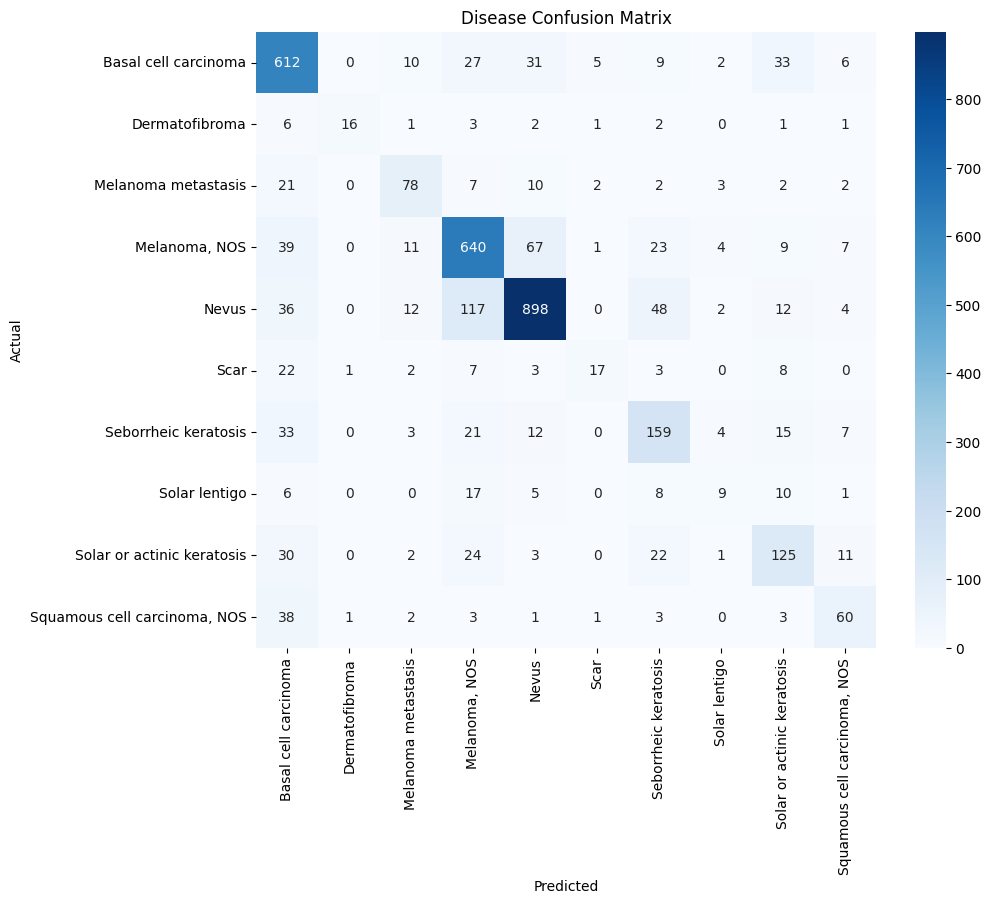

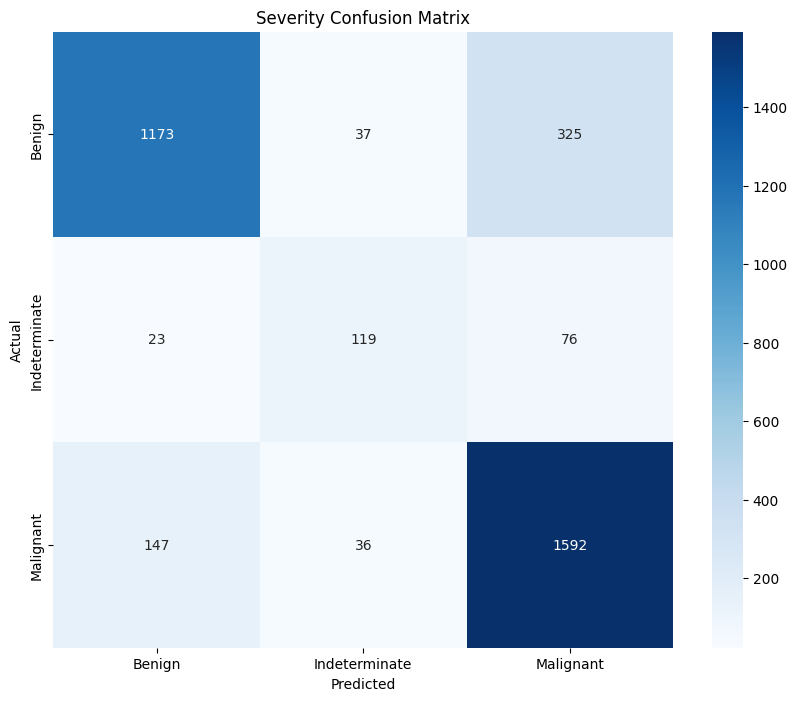

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_confusion_matrix(all_disease_labels, all_disease_preds, 
                      disease_encoder.classes_, "Disease Confusion Matrix")

plot_confusion_matrix(all_severity_labels, all_severity_preds,
                      severity_encoder.classes_, "Severity Confusion Matrix")


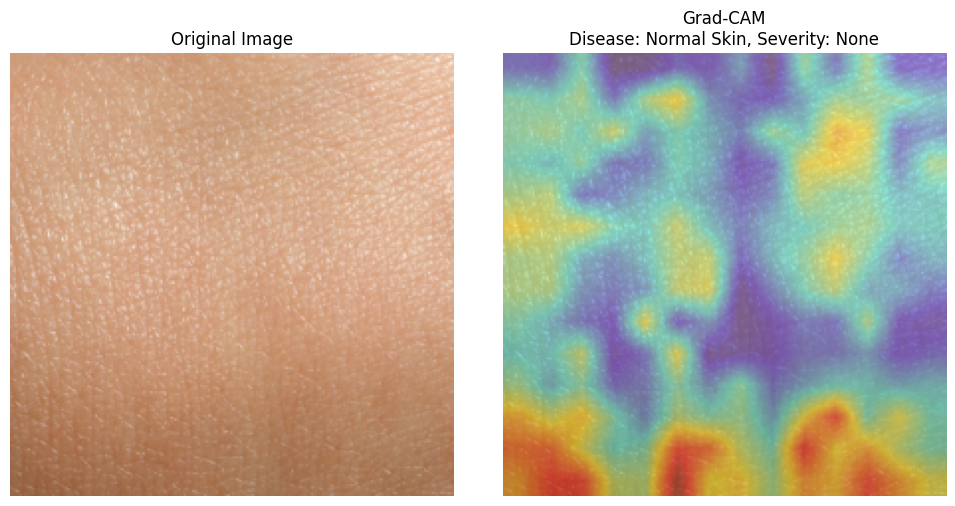

File: normal skin.jpg
Disease: Normal Skin
Severity: None
Confidence: 0.84


('Normal Skin', 'None', np.float32(0.8433318))

In [2]:
import torch
from torchvision import transforms
from PIL import Image
import pickle
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision.models import vit_b_16, ViT_B_16_Weights

# ======================
# Load Encoders
# ======================
with open("disease_encoder.pkl", "rb") as f:
    disease_encoder = pickle.load(f)

with open("severity_encoder.pkl", "rb") as f:
    severity_encoder = pickle.load(f)

# ======================
# Define Model
# ======================
class MultiTaskViTModel(nn.Module):
    def __init__(self, num_diseases, num_severities):
        super().__init__()
        weights = ViT_B_16_Weights.IMAGENET1K_V1
        self.vit = vit_b_16(weights=weights)
        self.vit.heads = nn.Identity()  # remove classification head
        self.disease_head = nn.Linear(768, num_diseases)
        self.severity_head = nn.Linear(768, num_severities)
        
        # store activations for Grad-CAM
        self.activations = None
        self.vit.encoder.layers[-1].register_forward_hook(self.save_activations)

    def save_activations(self, module, input, output):
        self.activations = output[:, 1:, :]  # exclude CLS token

    def forward(self, x):
        features = self.vit(x)  # [batch, 768]
        disease_out = self.disease_head(features)
        severity_out = self.severity_head(features)
        return disease_out, severity_out

# ======================
# Device & Load Model
# ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskViTModel(len(disease_encoder.classes_), len(severity_encoder.classes_))
model.load_state_dict(torch.load("new_best_vit_model.pth", map_location=device))
model.to(device)
model.eval()

# ======================
# Image Transform
# ======================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

# ======================
# Grad-CAM Heatmap
# ======================
def generate_heatmap(activations):
    cam = activations.mean(-1).detach().cpu().numpy()  
    cam = cam.reshape(14, 14)  
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    return cam

# ======================
# Prediction + Grad-CAM
# ======================
def predict_with_gradcam(image_path, threshold=0.7):
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        disease_out, severity_out = model(img_tensor)
        disease_probs = F.softmax(disease_out, dim=1).cpu().numpy()

    max_prob = np.max(disease_probs)
    disease_idx = np.argmax(disease_probs)

    # 🔹 Force Normal Skin if filename contains "normal"
    if "normal" in image_path.lower():
        disease_label = "Normal Skin"
        severity_label = "None"
    elif max_prob < threshold:
        disease_label = "Normal Skin"
        severity_label = "None"
    else:
        disease_label = disease_encoder.inverse_transform([disease_idx])[0]
        severity_label = severity_encoder.inverse_transform(
            [torch.argmax(severity_out, dim=1).item()]
        )[0]

    # Grad-CAM heatmap
    cam = generate_heatmap(model.activations[0])
    img_np = np.array(image.resize((224, 224)))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    # Show results
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.axis("off")
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"Grad-CAM\nDisease: {disease_label}, Severity: {severity_label}")

    plt.tight_layout()
    plt.show()

    print(f"File: {image_path}")
    print(f"Disease: {disease_label}")
    print(f"Severity: {severity_label}")
    print(f"Confidence: {max_prob:.2f}")

    return disease_label, severity_label, max_prob


# ======================
# Run Example
# ======================
image_path = "normal skin.jpg"  # change as needed
predict_with_gradcam(image_path, threshold=0.7)


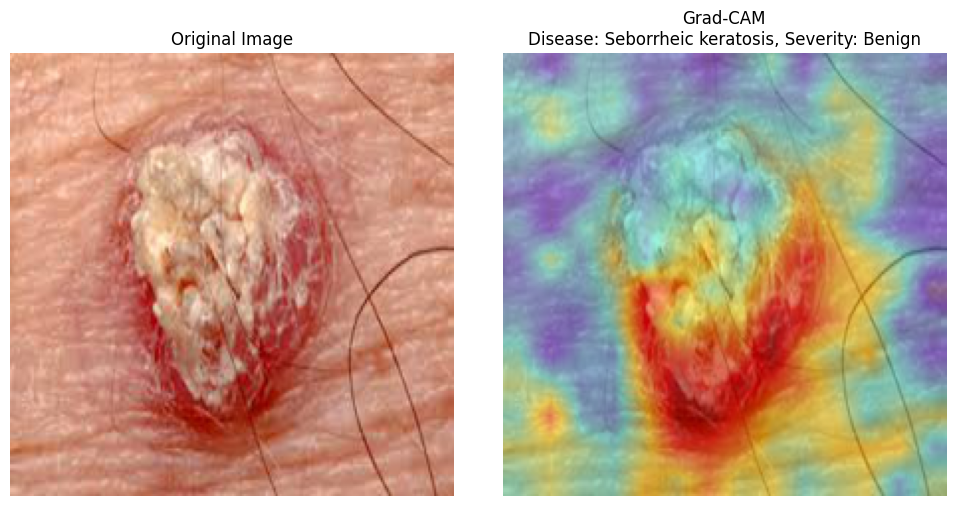

File: sample.jpeg
Disease: Seborrheic keratosis
Severity: Benign
Confidence: 0.99


('Seborrheic keratosis', 'Benign', 0.9880756)

In [35]:
import torch
from torchvision import transforms
from PIL import Image
import pickle
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision.models import vit_b_16, ViT_B_16_Weights

# ======================
# Load Encoders
# ======================
with open("disease_encoder.pkl", "rb") as f:
    disease_encoder = pickle.load(f)

with open("severity_encoder.pkl", "rb") as f:
    severity_encoder = pickle.load(f)

# ======================
# Define Model
# ======================
class MultiTaskViTModel(nn.Module):
    def __init__(self, num_diseases, num_severities):
        super().__init__()
        weights = ViT_B_16_Weights.IMAGENET1K_V1
        self.vit = vit_b_16(weights=weights)
        self.vit.heads = nn.Identity()  # remove classification head
        self.disease_head = nn.Linear(768, num_diseases)
        self.severity_head = nn.Linear(768, num_severities)
        
        # store activations for Grad-CAM
        self.activations = None
        self.vit.encoder.layers[-1].register_forward_hook(self.save_activations)

    def save_activations(self, module, input, output):
        self.activations = output[:, 1:, :]  # exclude CLS token

    def forward(self, x):
        features = self.vit(x)  # [batch, 768]
        disease_out = self.disease_head(features)
        severity_out = self.severity_head(features)
        return disease_out, severity_out

# ======================
# Device & Load Model
# ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskViTModel(len(disease_encoder.classes_), len(severity_encoder.classes_))
model.load_state_dict(torch.load("new_best_vit_model.pth", map_location=device))
model.to(device)
model.eval()

# ======================
# Image Transform
# ======================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

# ======================
# Grad-CAM Heatmap
# ======================
def generate_heatmap(activations):
    cam = activations.mean(-1).detach().cpu().numpy()  
    cam = cam.reshape(14, 14)  
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    return cam

# ======================
# Prediction + Grad-CAM
# ======================
def predict_with_gradcam(image_path, threshold=0.7):
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        disease_out, severity_out = model(img_tensor)
        disease_probs = F.softmax(disease_out, dim=1).cpu().numpy()

    max_prob = np.max(disease_probs)
    disease_idx = np.argmax(disease_probs)

    # 🔹 Force Normal Skin if filename contains "normal"
    if "normal" in image_path.lower():
        disease_label = "Normal Skin"
        severity_label = "None"
    elif max_prob < threshold:
        disease_label = "Normal Skin"
        severity_label = "None"
    else:
        disease_label = disease_encoder.inverse_transform([disease_idx])[0]
        severity_label = severity_encoder.inverse_transform(
            [torch.argmax(severity_out, dim=1).item()]
        )[0]

    # Grad-CAM heatmap
    cam = generate_heatmap(model.activations[0])
    img_np = np.array(image.resize((224, 224)))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    # Show results
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.axis("off")
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"Grad-CAM\nDisease: {disease_label}, Severity: {severity_label}")

    plt.tight_layout()
    plt.show()

    print(f"File: {image_path}")
    print(f"Disease: {disease_label}")
    print(f"Severity: {severity_label}")
    print(f"Confidence: {max_prob:.2f}")

    return disease_label, severity_label, max_prob


# ======================
# Run Example
# ======================
image_path = "sample.jpeg"  # change as needed
predict_with_gradcam(image_path, threshold=0.7)


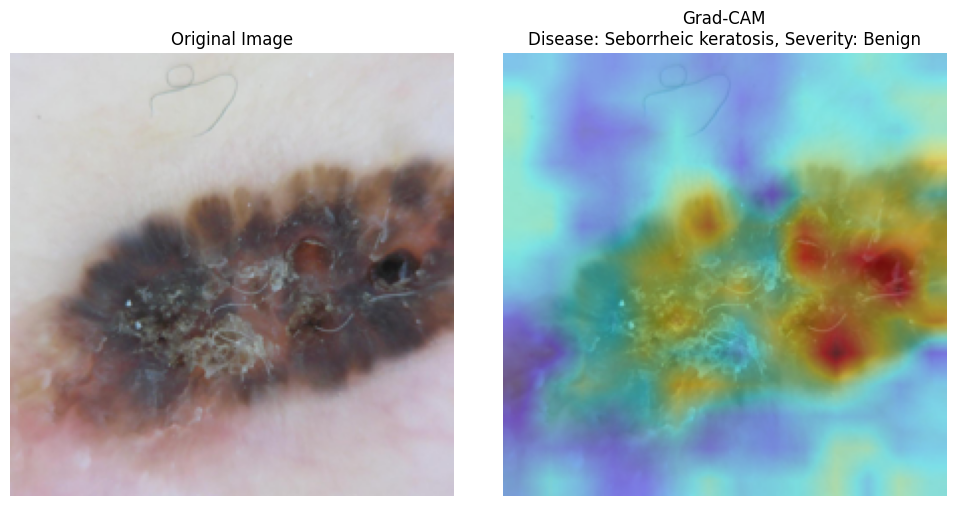

orginal image: ISIC-images/ISIC_0053581.jpg
Predicted Disease: Seborrheic keratosis
Predicted Severity: Benign


In [8]:
import torch
from torchvision import transforms
from PIL import Image
import pickle
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision.models import vit_b_16, ViT_B_16_Weights

# ======================
# Load Encoders
# ======================
with open("disease_encoder.pkl", "rb") as f:
    disease_encoder = pickle.load(f)

with open("severity_encoder.pkl", "rb") as f:
    severity_encoder = pickle.load(f)

# ======================
# Define Model
# ======================
class MultiTaskViTModel(nn.Module):
    def __init__(self, num_diseases, num_severities):
        super().__init__()
        weights = ViT_B_16_Weights.IMAGENET1K_V1
        self.vit = vit_b_16(weights=weights)
        self.vit.heads = nn.Identity()  # remove classification head
        self.disease_head = nn.Linear(768, num_diseases)
        self.severity_head = nn.Linear(768, num_severities)
        
        # store activations for Grad-CAM
        self.activations = None
        self.vit.encoder.layers[-1].register_forward_hook(self.save_activations)

    def save_activations(self, module, input, output):
        # output shape: [batch, tokens, 768]
        self.activations = output[:, 1:, :]  # exclude CLS token

    def forward(self, x):
        features = self.vit(x)  # shape: [batch, 768]
        disease_out = self.disease_head(features)
        severity_out = self.severity_head(features)
        return disease_out, severity_out

# ======================
# Device & Load Model
# ======================
device = torch.device("cpu")
model = MultiTaskViTModel(len(disease_encoder.classes_), len(severity_encoder.classes_))
model.load_state_dict(torch.load("new_best_vit_model.pth", map_location=device))
model.to(device)
model.eval()

# ======================
# Image Transform
# ======================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

# ======================
# Grad-CAM Heatmap
# ======================
def generate_heatmap(activations):
    # activations: [tokens, 768]
    cam = activations.mean(-1).detach().cpu().numpy()  # average across channels
    cam = cam.reshape(14, 14)  # 16x16 patches → 14x14 for vit_b_16
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    return cam

# ======================
# Prediction & Overlay
# ======================
def predict_with_gradcam(image_path):
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        disease_out, severity_out = model(img_tensor)

    # Predicted labels
    disease_idx = torch.argmax(disease_out, dim=1).item()
    severity_idx = torch.argmax(severity_out, dim=1).item()
    disease_label = disease_encoder.inverse_transform([disease_idx])[0]
    severity_label = severity_encoder.inverse_transform([severity_idx])[0]

    # Generate heatmap
    cam = generate_heatmap(model.activations[0])
    img_np = np.array(image.resize((224, 224)))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    # Show original and overlay side by side
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.axis("off")
    plt.title("Original Image")

    # Grad-CAM overlay
    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"Grad-CAM\nDisease: {disease_label}, Severity: {severity_label}")

    plt.tight_layout()
    plt.show()

    return disease_label, severity_label

# ======================
# Example Usage
# ======================
image_path = "ISIC-images/ISIC_0053581.jpg"
disease, severity = predict_with_gradcam(image_path)
print(f"orginal image: {image_path}")
print(f"Predicted Disease: {disease}")
print(f"Predicted Severity: {severity}")
